<a href="https://www.kaggle.com/code/yagelosergey/crop-yield-farm-anova?scriptVersionId=135926243" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=b55ad5b7a00559a4151070095105bf36b72d17d4575dbdd162e4de3a1e075289
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd

import pingouin as pg
plt.style.use('fivethirtyeight') 

### EDA

In [3]:
df = pd.read_csv('/kaggle/input/fdffa/field_data.csv')

In [4]:
df.head(3)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   height      96 non-null     int64  
 1   temp        96 non-null     int64  
 2   humidity    96 non-null     int64  
 3   fertilizer  96 non-null     int64  
 4   yield       96 non-null     float64
 5   region      96 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 4.6 KB


,height,temp,humidity,fertilizer,yield,region
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.500000,65.156250,70.031250,2.000000,397.015476,2.500000
std,0.502625,3.335071,6.793888,0.820783,0.664548,1.123903
min,1.000000,60.000000,60.000000,1.000000,395.360840,1.000000
25%,1.000000,62.000000,64.750000,1.000000,396.468696,1.750000
50%,1.500000,66.000000,69.000000,2.000000,397.058105,2.500000
75%,2.000000,68.000000,77.000000,3.000000,397.398571,3.250000
max,2.000000,70.000000,80.000000,3.000000,399.060899,4.000000


In [5]:
## create categorical variable for humidity and temp
bin_cols = ['temp', 'humidity']
for c in bin_cols:
    df[f'{c}_bins'] = pd.cut(df[c], bins=3, labels=[1,2,3])

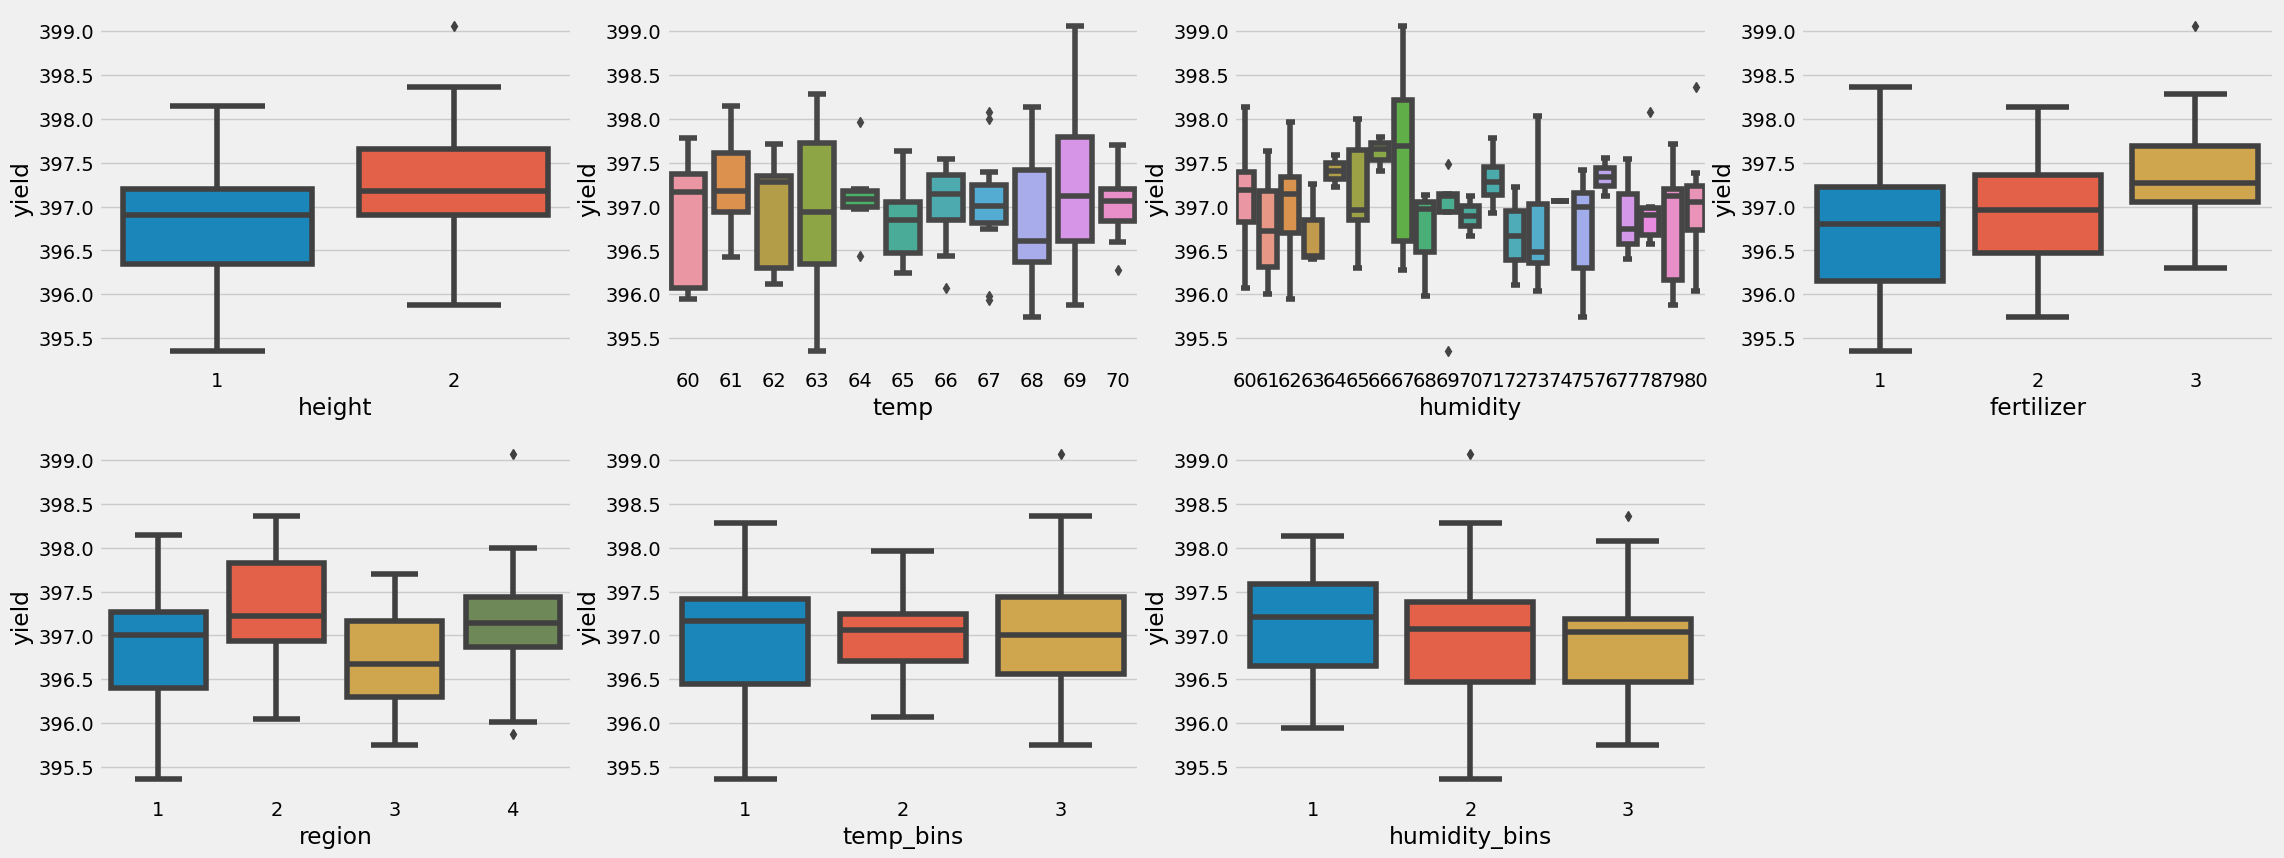

In [6]:
class SubBoxes:
    def __init__(self,data):
        self.data = data
        
    def plot(self):
        n = 1 
        fig = plt.figure(figsize=(25,15))
        for c in list(df.columns):
            if c != 'yield':
                ax = plt.subplot(3,4,n)
                sns.boxplot(data=self.data, x=c, y='yield')
                n += 1
SubBoxes(df).plot()

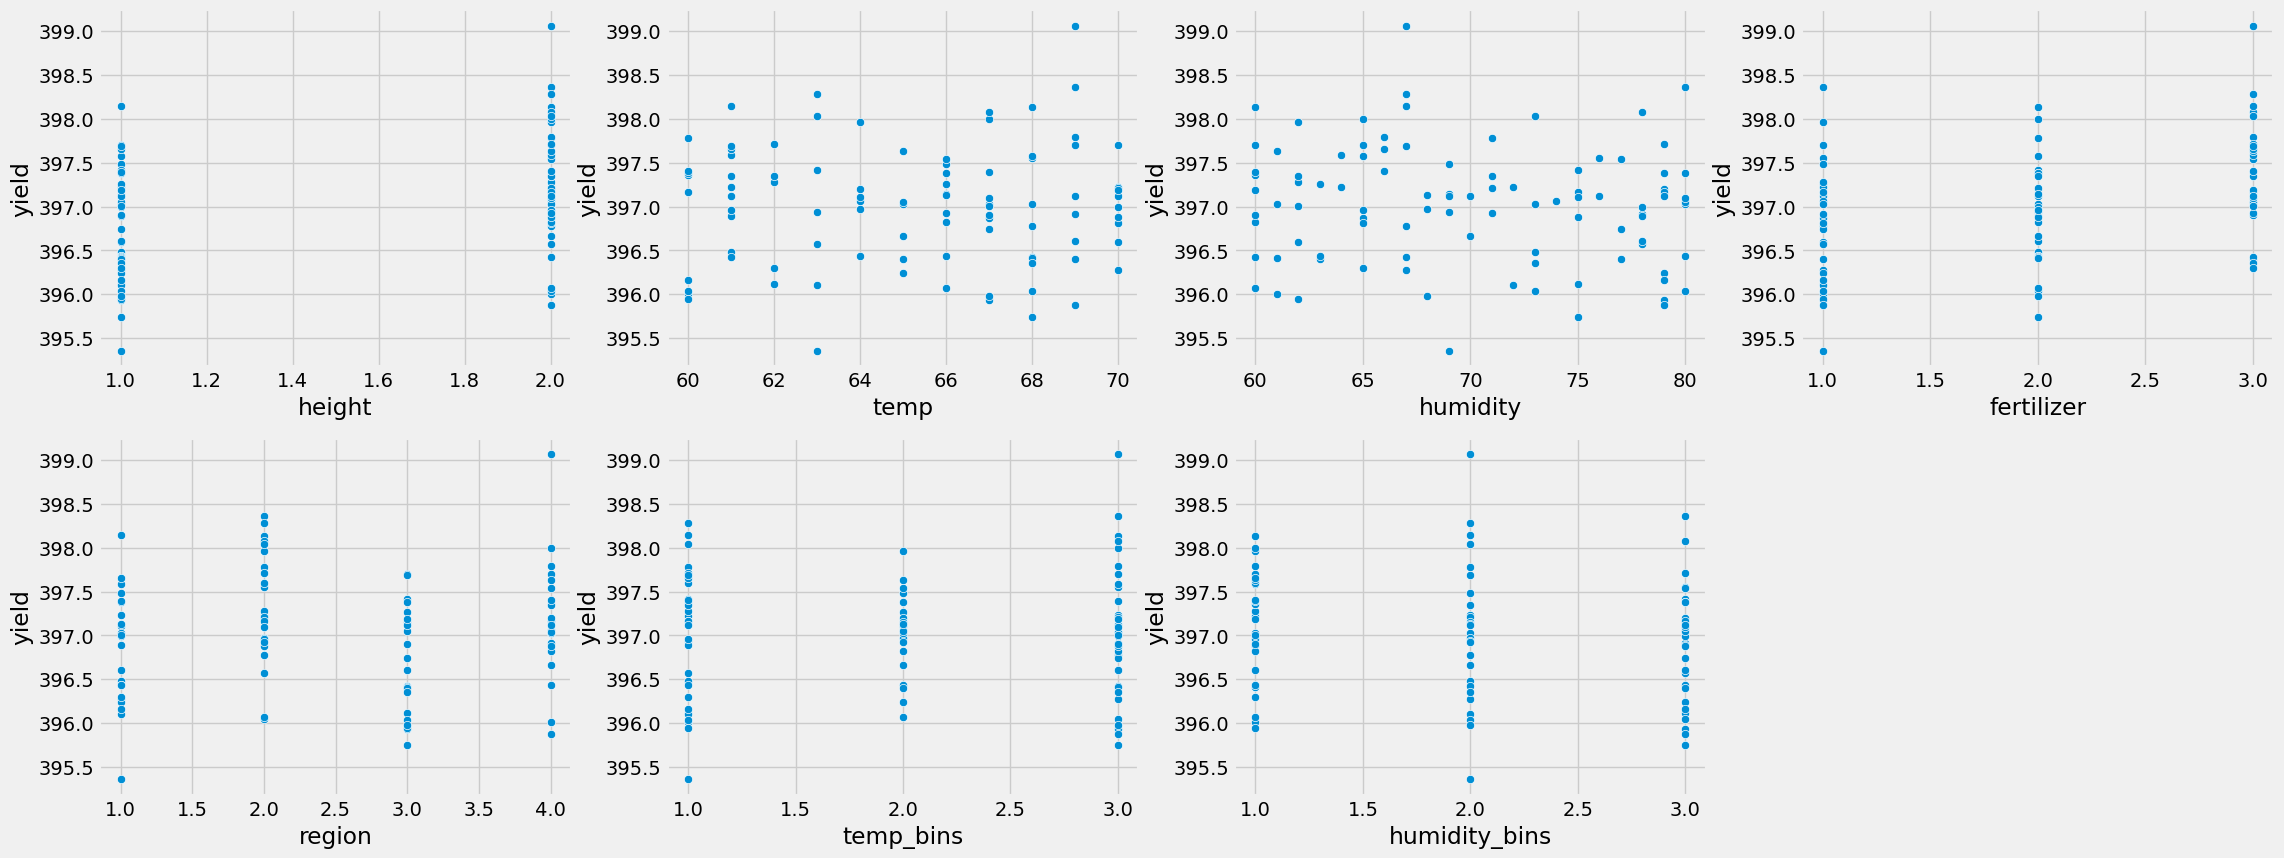

In [7]:
class SubScatter:
    def __init__(self,data):
        self.data = data
        
    def plot(self):
        n = 1 
        fig = plt.figure(figsize=(25,15))
        for c in list(df.columns):
            if c != 'yield':
                ax = plt.subplot(3,4,n)
                sns.scatterplot(data=self.data, x=c, y='yield')
                n += 1
SubScatter(df).plot()

<Axes: xlabel='yield', ylabel='Count'>

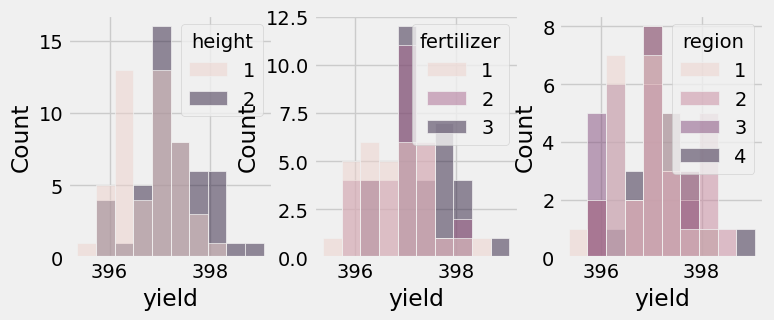

In [8]:
f, axs = plt.subplots(1, 3, figsize=(8, 3))
sns.histplot(data=df, x='yield', hue='height',ax=axs[0])
sns.histplot(data=df, x='yield', hue='fertilizer',ax=axs[1])
sns.histplot(data=df, x='yield', hue='region',ax=axs[2])

### ANOVA

In [9]:
results = pg.anova(data=df, dv='yield', between=['temp_bins', 'humidity_bins'])
results

,Source,SS,DF,MS,F,p-unc,np2
0,temp_bins,0.007939,2.0,0.003970,0.008501,0.991535,0.000195
1,humidity_bins,0.571428,2.0,0.285714,0.611908,0.544633,0.013872
2,temp_bins * humidity_bins,0.750744,4.0,0.187686,0.401963,0.806749,0.018146
3,Residual,40.622302,87.0,0.466923,NaN,NaN,NaN


In [10]:
results = pg.anova(data=df, dv='yield', between=['height','fertilizer'])
results

,Source,SS,DF,MS,F,p-unc,np2
0,height,5.121681,1,5.121681,15.194518,0.000186,0.144442
1,fertilizer,6.068047,2,3.034023,9.001052,0.000273,0.166683
2,height * fertilizer,0.427818,2,0.213909,0.634605,0.532500,0.013906
3,Residual,30.336687,90,0.337074,NaN,NaN,NaN


In [11]:
results = pg.anova(data=df, dv='yield', between=['region'])
results

,Source,ddof1,ddof2,F,p-unc,np2
0,region,3,92,4.731503,0.004086,0.133665


In [12]:
# analogue of the t-tests for multi-comparison
def tukey_comparison(en, gr):
    tukey = pairwise_tukeyhsd(endog=en,
                               groups=gr,
                               alpha=0.05)
    tukey.plot_simultaneous()
    print(tukey.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.4605 0.0607 -0.0143  0.9353  False
     1      3  -0.1438 0.8577 -0.6185   0.331  False
     1      4   0.3196 0.2984 -0.1551  0.7944  False
     2      3  -0.6043 0.0067  -1.079 -0.1295   True
     2      4  -0.1409  0.865 -0.6156  0.3339  False
     3      4   0.4634 0.0584 -0.0114  0.9382  False
----------------------------------------------------


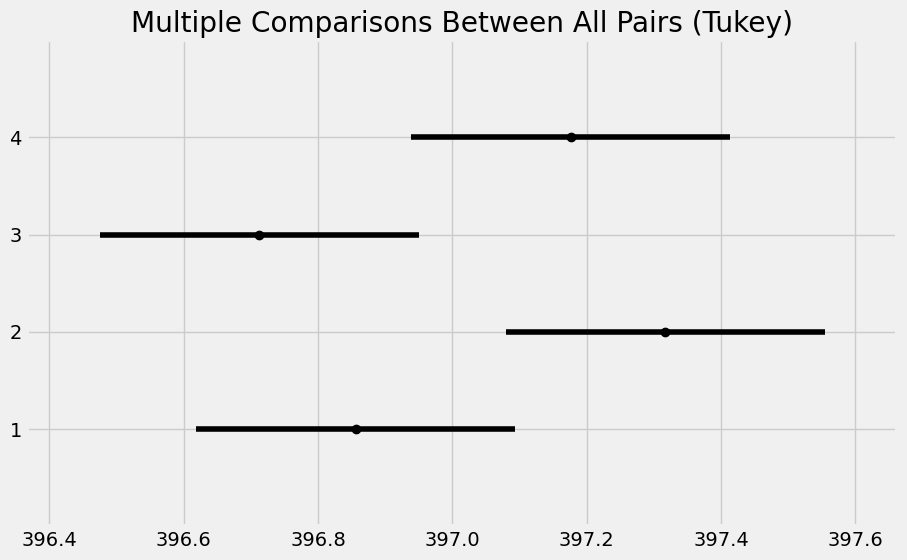

In [13]:
tukey_comparison(en=df['yield'], gr=df['region'])

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2    0.462 0.0005 0.2083 0.7157   True
--------------------------------------------------


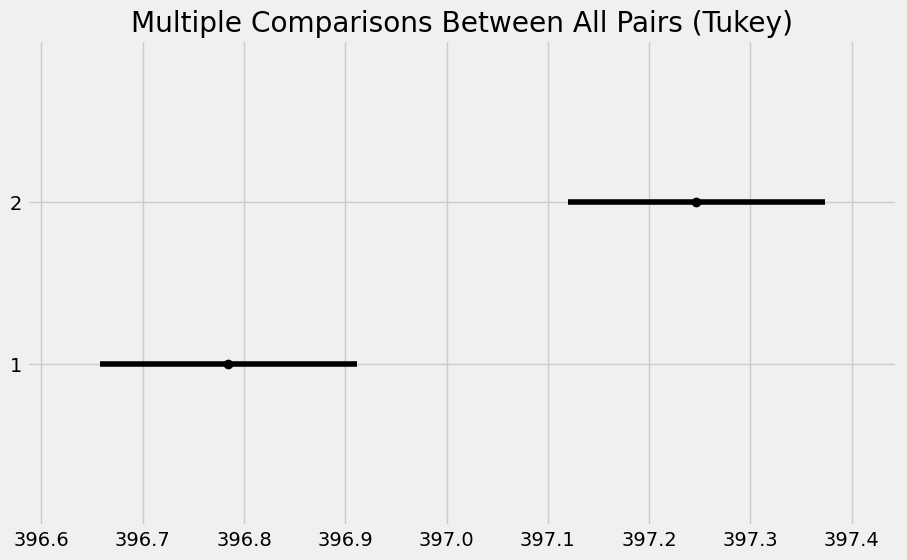

In [14]:
tukey_comparison(en=df['yield'], gr=df['height'])

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.1762 0.4955 -0.1937 0.5461  False
     1      3   0.5991 0.0006  0.2292  0.969   True
     2      3    0.423 0.0209  0.0531 0.7928   True
---------------------------------------------------


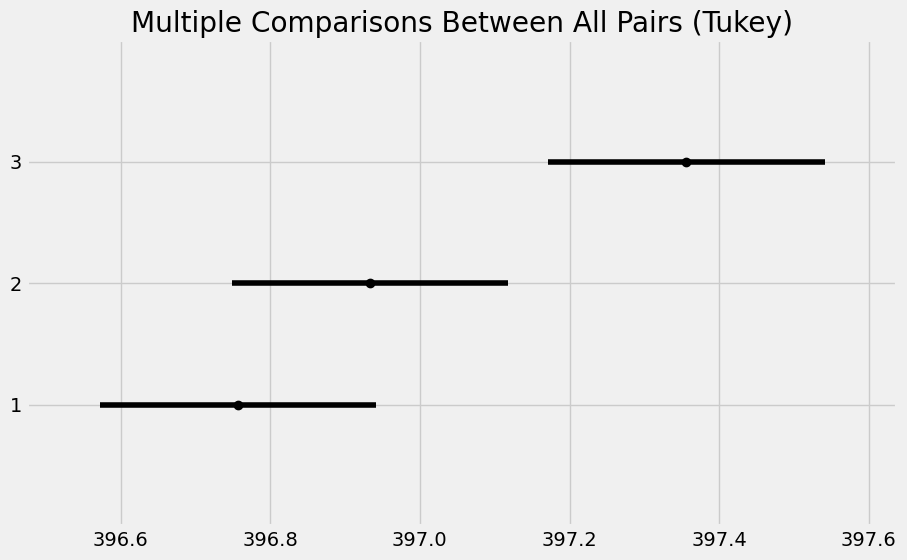

In [15]:
tukey_comparison(en=df['yield'], gr=df['fertilizer'])

#### Conclusion
Only fertilizer and height have statistically significant differences. Region has a different only between region 2 and region 3